# Forcasting trend with AR, MA & ARIMA

In [1]:
library(tidyverse)
library(forecast)
library(ggplot2)
library(dplyr)
library(data.table)
library(IRdisplay)

library(foreach)
library(doParallel)

library(caret)
library(randomForest)
library(reshape2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff

Attaching package: 'data.table'

The following ob

### Display tables

In [2]:
# Custom display function for the first and last 5 rows or full table if <= 20 rows
display_limited <- function(dt) {
  n <- nrow(dt)
  
  # If there are 20 or fewer rows, display the full table
  if (n <= 20) {
    limited_dt <- dt
  } else {
    # Otherwise, concatenate the first 5 rows, '...' and the last 5 rows
    limited_dt <- rbind(head(dt, 5), as.list(rep("...", ncol(dt))), tail(dt, 5))
  }
  
  # Generate raw HTML manually
  html_output <- paste0(
    "<table border='1' style='border-collapse:collapse;'>",
    "<thead><tr>",
    paste0("<th>", colnames(limited_dt), "</th>", collapse = ""),
    "</tr></thead>",
    "<tbody>",
    paste0(
      apply(limited_dt, 1, function(row) {
        paste0("<tr>", paste0("<td>", row, "</td>", collapse = ""), "</tr>")
      }),
      collapse = ""
    ),
    "</tbody></table>"
  )
  
  # Display the HTML in the Jupyter notebook
  display_html(html_output)
}


### Calculate metrics

In [3]:
calculate_metrics <- function(R_t, R_hat_t, individual) {
  # Ensure the inputs are numeric vectors and individual is a dataframe
  if (!is.numeric(R_t) || !is.numeric(R_hat_t)) {
    stop("Both R_t and R_hat_t need to be numeric vectors.")
  }
  
  # Calculate metrics
  mae <- mean(abs(R_t - R_hat_t), na.rm = TRUE)
  rmse <- sqrt(mean((R_t - R_hat_t)^2, na.rm = TRUE))
  mape <- mean(abs((R_t - R_hat_t) / R_t), na.rm = TRUE) * 100
  r_squared <- ifelse(all(R_t == R_hat_t), 1, summary(lm(R_t ~ R_hat_t))$r.squared)
  
  # Create a data frame to hold the metrics and values
  metrics_table <- data.frame(
    MAE = mae,
    RMSE = rmse,
    MAPE = mape,
    R_squared = r_squared
  )
  
  # Return the metrics table
  return(metrics_table)
}

### Data Preparation

In [4]:
prepare_X_t <- function(individual) {
  # Ensure the input is a dataframe
  if (!is.data.frame(individual)) {
    stop("The input must be a dataframe.")
  }
  
  # Extract hour from start_time and create a 'time_of_day' column
  individual$time_of_day <- format(as.POSIXct(individual$HourDK), "%H:%M:%S")
  
  # Exclude specified columns but keep 'time_of_day'
  X_t <- subset(individual, select = -c(HourDK, GrossConsumptionMWh))
  
  # Convert month, weekday, and time_of_day to factors with a reference category
  X_t$month <- relevel(as.factor(X_t$MonthOfYear), ref = "December")  # Set December as reference
  X_t$weekday <- relevel(as.factor(X_t$DayOfWeek), ref = "Sunday")   # Set Sunday as reference 
  X_t$time_of_day <- relevel(as.factor(X_t$Hour), ref = "0")         # Set 23 (11 PM) as reference

  # Remove original 'MonthOfYear', 'DayOfWeek', and 'Hour' columns to avoid duplication
  X_t <- subset(X_t, select = -c(MonthOfYear, DayOfWeek, Hour))
  
  # Create dummy variables for all factor columns (excluding reference levels)
  X_t <- model.matrix(~ . - 1, data = X_t)
  
  # Find the column indices for numerical columns AFTER creating dummy variables
  num_cols <- grep("^(Electric cars|Plug-in hybrid cars|humidity_past1h|temp_mean_past1h|wind_speed_past1h|EL_price)", colnames(X_t))
  
  # Standardize selected numerical columns
  X_t[, num_cols] <- apply(X_t[, num_cols], 2, 
                           function(x) (x - min(x)) / (max(x) - min(x)))
  
  # Return the processed dataframe
  return(as.data.frame(X_t))
}


### Lag and Align data by \\(h\\) (horizon)

In [5]:
lag_and_align_data <- function(X_t, R_t, h = 1) {
  # Validate inputs
  if (!is.numeric(R_t)) {
    stop("R_t should be a numeric vector.")
  }
  if (!is.data.frame(X_t) && !is.matrix(X_t)) {
    stop("X_t should be a dataframe or a matrix.")
  }
  if (!is.numeric(h) || h < 1) {
    stop("h should be a positive integer.")
  }
  
  # Convert X_t to a dataframe if it's a matrix
  if (is.matrix(X_t)) {
    X_t <- as.data.frame(X_t)
  }
  
  # Align R_t with the lagged X_t
  # Shift R_t by h positions to align with X_t from the previous timestep
  R_t_aligned <- R_t[(h + 1):length(R_t)]
  
  # Keep X_t up to the second to last row, so it aligns with the shifted R_t
  X_t_aligned <- X_t[1:(nrow(X_t) - h), ]
  
  # Return the aligned datasets
  list(X_t = X_t_aligned, Y_t = R_t_aligned)
}

## Loading data

In [6]:
##### Setting workign directory and loadign data #####
base_path <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data Cleaning"
setwd(base_path)
data <- fread(paste0(base_path,"/Output_file.csv"))
MSTL <- fread(paste0(base_path,"/MSTL_decomp_results.csv"))

In [7]:
h=720
# Define train size
train_size    <- 17544 #2 year training set
#train_size    <- 8784  # 1 year training set

In [8]:
individual <- data
X_t <- prepare_X_t(as.data.frame(individual))
T_t <- as.matrix(MSTL$Trend, nrow = nrow(MSTL), ncol = 1)

lag_and_align <- lag_and_align_data(X_t, T_t, h = h)
X_t_OLS <- as.matrix(lag_and_align$X_t)
T_t_OLS <- as.numeric(lag_and_align$Y_t)

In [10]:
# Split the data into training and testing sets
X_train <- X_t[1:train_size, , drop = FALSE]
T_train <- T_t[1:train_size]
X_test  <- X_t[(train_size + 1):nrow(X_t), , drop = FALSE]
T_test  <- T_t[(train_size + 1):length(T_t)]

X_train_OLS <- X_t_OLS[1:train_size, , drop = FALSE]
T_train_OLS <- T_t_OLS[1:train_size]
X_test_OLS  <- X_t_OLS[(train_size + 1):nrow(X_t_OLS), , drop = FALSE]
T_test_OLS  <- T_t_OLS[(train_size + 1):length(T_t_OLS)]

# Fit OLS model
ols_model <- lm(T_train_OLS ~ ., data = as.data.frame(X_train_OLS))

# Predict on the test set
T_hat_t <- predict(ols_model, newdata = as.data.frame(X_test_OLS))

Warning message in predict.lm(ols_model, newdata = as.data.frame(X_test_OLS)):
"prediction from a rank-deficient fit may be misleading"

In [13]:
individual_metrics <- calculate_metrics(tail(T_t, n = length(T_t_OLS) - train_size), T_hat_t, data)
display_limited(individual_metrics)

MAE,RMSE,MAPE,R_squared
169.80146545762,208.567217892588,4.24299393731495,0.0963218818818074


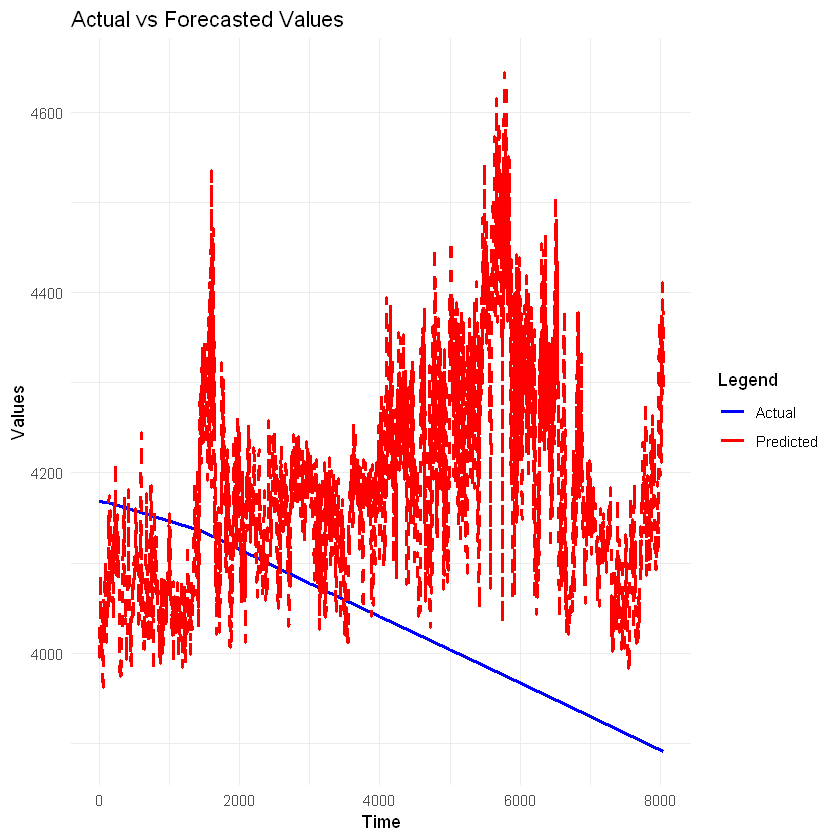

In [14]:
# Create a data frame for plotting
plot_data <- data.frame(
  Time = 1:length(T_test_OLS),  # Assuming sequential time indices
  Actual = T_test_OLS,
  Predicted = T_hat_t  # Your forecasted values
)

# Plot the actual vs. predicted values
ggplot(plot_data, aes(x = Time)) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted"), size = 1, linetype = "dashed") +
  labs(title = "Actual vs Forecasted Values",
       x = "Time",
       y = "Values",
       color = "Legend") +
  theme_minimal() +
  scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))


In [15]:
# Fit AR model (Auto-Regressive)
ar_model <- arima(T_train, order = c(1, 0, 0))  # AR(1) model

# Fit MA model (Moving Average)
ma_model <- arima(T_train, order = c(0, 0, 1))  # MA(1) model

# Fit ARMA model
arma_model <- arima(T_train, order = c(1, 0, 1))  # ARMA(1,1) model

# Fit ARIMA model
arima_model <- arima(T_train, order = c(1, 1, 1))  # ARIMA(1,1,1) model

# Fit best ARIMA model
auto_arima_model <- auto.arima(T_train, 
  max.p = 5,
  max.q = 5,
  max.P = 2,
  max.Q = 2) # ARIMA crossvalidated for best results

print(auto_arima_model)

Series: T_train 
ARIMA(0,2,0) 

sigma^2 estimated as 0.001694:  log likelihood=129452.1
AIC=-258902.3   AICc=-258902.3   BIC=-258894.5


In [16]:
# Generate predictions for each model
ols_pred <- predict(ols_model, newdata = as.data.frame(X_test))
ar_pred <- forecast(ar_model, h = length(T_test))$mean
ma_pred <- forecast(ma_model, h = length(T_test))$mean
arma_pred <- forecast(arma_model, h = length(T_test))$mean
arima_pred <- forecast(arima_model, h = length(T_test))$mean
auto_arima_pred <- forecast(auto_arima_model, h = length(T_test))$mean

Warning message in predict.lm(ols_model, newdata = as.data.frame(X_test)):
"prediction from a rank-deficient fit may be misleading"

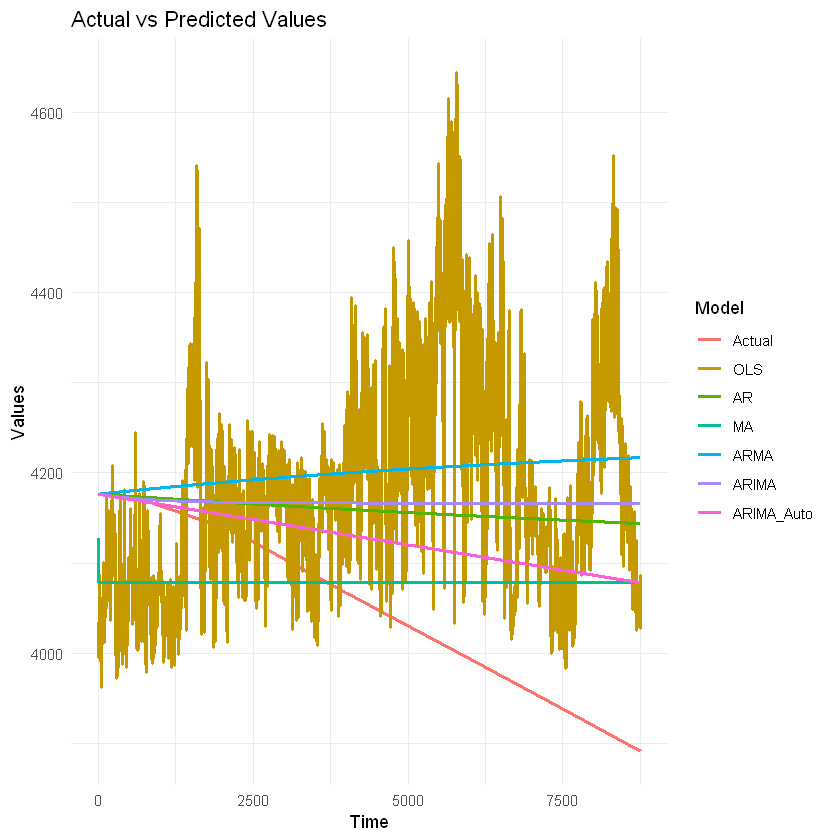

In [17]:
# Load necessary libraries
library(forecast)
library(ggplot2)


# Check and align the length of OLS predictions
if (length(ols_pred) != length(T_test)) {
  ols_pred <- ols_pred[1:length(T_test)]  # Adjust length if necessary
}

# Check and align lengths of all predictions to match T_test
predictions_list <- list(ols_pred, ar_pred, ma_pred, arma_pred, arima_pred, auto_arima_pred)
predictions_list <- lapply(predictions_list, function(pred) {
  if (length(pred) != length(T_test)) {
    return(pred[1:length(T_test)])
  } else {
    return(pred)
  }
})

# Create a data frame for plotting
plot_data    <- data.frame(
  Time       = 1:length(T_test),
  Actual     = T_test,
  OLS        = as.numeric(predictions_list[[1]]),
  AR         = as.numeric(predictions_list[[2]]),
  MA         = as.numeric(predictions_list[[3]]),
  ARMA       = as.numeric(predictions_list[[4]]),
  ARIMA      = as.numeric(predictions_list[[5]]),
  ARIMA_Auto = as.numeric(predictions_list[[6]])
)

# Melt the data frame for ggplot2 compatibility
plot_data_melted <- melt(plot_data, id.vars = "Time", variable.name = "Model", value.name = "Value")

# Plot the actual values and predictions
ggplot(plot_data_melted, aes(x = Time, y = Value, color = Model)) +
  geom_line(size = 1) +
  labs(title = "Actual vs Predicted Values",
       x = "Time",
       y = "Values",
       color = "Model") +
  theme_minimal()


In [113]:
# List of model predictions
model_predictions <- list(
  OLS = ols_pred,
  AR = ar_pred,
  MA = ma_pred,
  ARMA = arma_pred,
  ARIMA = arima_pred,
  Auto_ARIMA = auto_arima_pred
)

# Data frame to store metrics for each model
metrics_table <- data.frame(Model = character(), MAE = numeric(), RMSE = numeric(), MAPE = numeric(), R_squared = numeric(), stringsAsFactors = FALSE)

# Calculate metrics for each model and store in the metrics table
for (model_name in names(model_predictions)) {
  pred <- model_predictions[[model_name]]
  metrics <- calculate_metrics(T_test, pred, individual = NULL)
  
  # Add model name to the metrics
  metrics$Model <- model_name
  
  # Append to the metrics table
  metrics_table <- rbind(metrics_table, metrics)
}

# Reorder columns to have Model as the first column
metrics_table <- metrics_table[, c("Model", "MAE", "RMSE", "MAPE", "R_squared")]

# Print the metrics table
print(metrics_table)


       Model       MAE      RMSE     MAPE    R_squared
1        OLS 169.80147 208.56722 4.242994 0.0963218819
2         AR 116.24065 138.92776 2.918506 0.9924379881
3         MA  81.56989  98.72548 2.044522 0.0003013632
4       ARMA 148.94092 175.39719 3.737013 0.9725434039
5      ARIMA 121.38398 146.53995 3.048996 0.4553674877
6 Auto_ARIMA  84.64943 102.24859 2.126326 0.9982800162


In [102]:
summary(ols_model)


Call:
lm(formula = T_train ~ ., data = as.data.frame(X_train))

Residuals:
    Min      1Q  Median      3Q     Max 
-385.62  -64.31   -0.49   64.09  204.94 

Coefficients: (1 not defined because of singularities)
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 3996.2430     6.9031 578.909  < 2e-16 ***
IsHoliday                     10.9143     3.4390   3.174 0.001508 ** 
humidity_past1h               28.2268     4.2424   6.653 2.95e-11 ***
temp_mean_past1h            -150.4411     8.9288 -16.849  < 2e-16 ***
wind_speed_past1h             39.2234     5.0919   7.703 1.40e-14 ***
`\\`Electric cars\\``       6785.1361   243.4937  27.866  < 2e-16 ***
`\\`Plug-in hybrid cars\\`` 1288.2062   152.1128   8.469  < 2e-16 ***
EL_price                     793.1545    11.9569  66.334  < 2e-16 ***
time_of_day0                   0.6294     3.8738   0.162 0.870939    
time_of_day1                   2.5410     3.8759   0.656 0.512092    
time_of_day2    

In [112]:
       Model       MAE      RMSE     MAPE R_squared
1        OLS 177.28754 223.16793 4.421407 0.1084263
2         AR 109.55800 134.79822 2.749181 0.9844070
3         MA  79.06102  92.82007 1.970092 0.0000000
4       ARMA 150.43325 180.18323 3.770186 0.9627788
5      ARIMA 118.10806 146.42337 2.964742 0.4087221
6 Auto_ARIMA  77.90538  98.09097 1.956920 0.9943862

ERROR: Error in parse(text = x, srcfile = src): <text>:1:20: uventet symbol
1:        Model       MAE
                       ^


In [ ]:
       Model       MAE      RMSE     MAPE    R_squared
1        OLS 169.80147 208.56722 4.242994 0.0963218819
2         AR 116.24065 138.92776 2.918506 0.9924379881
3         MA  81.56989  98.72548 2.044522 0.0003013632
4       ARMA 148.94092 175.39719 3.737013 0.9725434039
5      ARIMA 121.38398 146.53995 3.048996 0.4553674877
6 Auto_ARIMA  84.64943 102.24859 2.126326 0.9982800162
7XGB_f24_100  26.378   43.737081 0.647259 0.7452727245

In [ ]:
MAE	                RMSE	            MAPE	R_squared
